In [190]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
import math
import time
from copy import deepcopy
import dill as pickle
import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import torch
from matplotlib import ticker
from pyloric import create_prior, simulate, summary_stats
from pyloric.utils import energy_of_membrane, energy_of_synapse
from sbi.analysis import ActiveSubspace

import stg_energy.fig3_active_subspaces.viz as viz
from stg_energy.fig3_active_subspaces.helper_functions import nth_argmax, nth_argmin
from sklearn.linear_model import LinearRegression
from sbi.analysis import pairplot
from stg_energy.common import get_labels_8pt, generate_labels_for_pairplot, generate_labels_for_pairplot_no_whitespace
import matplotlib.patheffects as pe

# Figure 3

In [192]:
pd.options.display.max_columns = 999

In [193]:
PANEL_A = "../svg/panel_a.svg"
PANEL_B = "../svg/panel_b.svg"
PANEL_B_lin = "../svg/panel_b_lin.svg"
PANEL_B_raw = "../svg/panel_b_raw.svg"
PANEL_C = "../svg/panel_c.svg"
PANEL_D = "../svg/panel_d.svg"
PANEL_E1 = "../svg/panel_e1.svg"
PANEL_E2 = "../svg/panel_e2.svg"
PANEL_F1 = "../svg/panel_f1.svg"
PANEL_F1_raw = "../svg/panel_f1_raw.svg"
PANEL_F2 = "../svg/panel_f2.svg"
PANEL_G1 = "../svg/panel_g1.svg"
PANEL_G2 = "../svg/panel_g2.svg"
PANEL_H1 = "../svg/panel_h1.svg"
PANEL_H2 = "../svg/panel_h2.svg"
PANEL_I1 = "../svg/panel_i1.svg"
PANEL_I2 = "../svg/panel_i2.svg"
PANEL_Synapses_reduction = "../svg/panel_synapses_reduction.svg"

PANEL_supp_EV1 = "../svg/panel_supp_ev1.svg"
PANEL_supp_EV2 = "../svg/panel_supp_ev2.svg"
PANEL_supp_EV3 = "../svg/panel_supp_ev3.svg"

PANEL_supp_shift1 = "../svg/panel_supp_shift1.svg"
PANEL_supp_shift2 = "../svg/panel_supp_shift2.svg"
PANEL_supp_shift3 = "../svg/panel_supp_shift3.svg"
PANEL_supp_shift4 = "../svg/panel_supp_shift4.svg"
PANEL_supp_shift5 = "../svg/panel_supp_shift5.svg"
PANEL_supp_shift6 = "../svg/panel_supp_shift6.svg"
PANEL_supp_shift7 = "../svg/panel_supp_shift7.svg"

PANEL_supp_performance1 = "../svg/panel_supp_performance1.svg"
PANEL_supp_performance2 = "../svg/panel_supp_performance2.svg"
PANEL_supp_performance3 = "../svg/panel_supp_performance3.svg"

PANEL_supp_synapses1 = "../svg/panel_supp_synapses1.svg"
PANEL_supp_synapses2 = "../svg/panel_supp_synapses2.svg"
PANEL_supp_synapses3 = "../svg/panel_supp_synapses3.svg"

PANEL_NEW_A = "../svg/panel_new_a_inkscape.svg"

PANEL_NEW_F1 = "../svg/panel_new_f1.svg"
PANEL_NEW_F2 = "../svg/panel_new_f2.svg"

PANEL_NEW_G1 = "../svg/panel_new_g1.svg"
PANEL_NEW_G2 = "../svg/panel_new_g2.svg"
PANEL_NEW_supp_params_11 = "../svg/PANEL_NEW_supp_params_11.svg"
PANEL_NEW_supp_params_12 = "../svg/PANEL_NEW_supp_params_12.svg"
PANEL_NEW_supp_params_21 = "../svg/PANEL_NEW_supp_params_21.svg"
PANEL_NEW_supp_params_22 = "../svg/PANEL_NEW_supp_params_22.svg"

PANEL_MECH_KD_A = "../svg/panel_mech_kd_a_new.svg"
PANEL_MECH_KD_B = "../svg/panel_mech_kd_b_new.svg"
PANEL_MECH_KD_C = "../svg/panel_mech_kd_c_new.svg"
PANEL_MECH_KD_D = "../svg/panel_mech_kd_d_new.svg"
PANEL_MECH_KD_E = "../svg/panel_mech_kd_e_new.svg"
PANEL_MECH_KD_F = "../svg/panel_mech_kd_f_new.svg"
PANEL_MECH_KD_voltage = "../svg/panel_mech_kd_voltage_new.svg"
PANEL_lin_reg = "../svg/panel_lin_reg.svg"
PANEL_degeneracy_plot = "../svg/panel_degeneracy_plot.svg"

PANEL_supp_mean_shift = "../svg/panel_supp_mean_shift.svg"
PANEL_supp_mean_shift_syn = "../svg/panel_supp_mean_shift_syn.svg"

### Load experimental data

In [194]:
prior_11 = create_prior()

In [195]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

theta_np = theta.to_numpy()
x_np = x.to_numpy()

In [196]:
cols_hex = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
    "#66a61e",
    "#e6ab02",
    "#a6761d",
    "#666666",
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
    "#66a61e",
    "#e6ab02",
    "#a6761d",
    "#666666",
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
    "#66a61e",
    "#e6ab02",
    "#a6761d",
    "#666666",
#     "k",
#     "k",
#     "k",
#     "k",
#     "k",
#     "k",
#     "k",
]
cols = np.asarray(cols_hex)

### Simulate 10 samples and keep track of the energy consumption of each trace

In [197]:
def simulator(p_with_s):
    circuit_params = np.asarray([p_with_s[:-1]])
    theta_pd = pd.DataFrame(circuit_params, columns=theta.columns)
    out_target = simulate(
        theta_pd.loc[0], seed=int(p_with_s[-1]), track_energy=True, track_currents=True
    )
    all_energies = energy_of_membrane(out_target)
    synaptic_energies = energy_of_synapse(out_target)

    summed_energy_each_current = np.sum(all_energies, axis=2)
    summed_energy_synapses = np.sum(synaptic_energies, axis=1)
    summed_energy_total = np.sum(all_energies) + np.sum(synaptic_energies)
    fraction_of_each_current = summed_energy_each_current / summed_energy_total
    fraction_of_synapse = summed_energy_synapses / summed_energy_total
    return (fraction_of_each_current, fraction_of_synapse)

In [198]:
# torch.manual_seed(0)
# params_with_seeds = np.concatenate(
#     (
#         theta_np[:200],
#         seeds[:200][
#             None,
#         ].T,
#     ),
#     axis=1,
# )
# simulation_outputs = list(map(simulator, params_with_seeds))
simulation_outputs = np.load("../../../results/simulation_data_Tube_MLslurm_cluster/twohundred_predictives_individual_currents.npy", allow_pickle=True)

In [199]:
# np.save("../../../results/simulation_data_Tube_MLslurm_cluster/twohundred_predictives_individual_currents.npy", simulation_outputs)

In [200]:
all_e_cur = []
all_e_syn = []
for so in simulation_outputs:
    e_cur, e_syn = so
    all_e_cur.append(e_cur)
    all_e_syn.append(e_syn)

all_e_cur = np.asarray(all_e_cur)
all_e_syn = np.asarray(all_e_syn)
fractions = np.mean(all_e_cur, axis=0)
synapse_fractions = np.mean(all_e_syn, axis=0)

In [201]:
summed_energy_synapses = np.sum(all_e_syn, axis=1)

In [202]:
summed_energy_membrane = np.sum(np.sum(all_e_cur, axis=1), axis=1)

In [203]:
fraction_between_them = summed_energy_synapses / (summed_energy_membrane + summed_energy_synapses)

In [204]:
print("Fraction of energy consumed by synapses:   ", np.mean(fraction_between_them)*100, "%")

Fraction of energy consumed by synapses:    0.07815773482273314 %


In [205]:
current_fractions = fractions.T.flatten()
all_fractions = np.concatenate((current_fractions, synapse_fractions))
all_fractions /= np.linalg.norm(all_fractions)

###  Fit regression net for total energy

In [207]:
import sys
sys.path.append("home/michael/Documents/sbi/sbi/utils/user_input_checks_utils")

In [208]:
import sys
from sbi.utils import user_input_checks_utils

sys.modules["sbi.user_input.user_input_checks_utils"] = user_input_checks_utils

In [209]:
with open(
    "../../../results/trained_neural_nets/inference/posterior_11deg.pickle", "rb"
) as handle:
    posterior = pickle.load(handle)
    posterior._device = 'cpu'

/home/michael/Documents/STG_energy_sbi/sbi/inference/posteriors/base_posterior.py:1089: UserWarning: You had saved the posterior under an older version of `sbi`. To make the loaded version comply with the version you are using right now, we had to set the following attributes: `self._device = cpu` `self._num_iid_trials = None` `self._iid_methods = ['snle', 'snre_a', 'snre_b']` `self._allow_iid_x = False` `self._sample_with = rejection`
  warn(warning_description + warning_msg)


In [210]:
xo = np.load("../../../results/experimental_data/xo_11deg.npy")

In [211]:
energies = x["energies"]

In [212]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

In [213]:
num_test = 1000

theta_test = torch.as_tensor(theta_np[:num_test], dtype=torch.float32)
theta_train = torch.as_tensor(theta_np[num_test:], dtype=torch.float32)

In [214]:
train_energy = torch.as_tensor(
    torch.sum(energies_tt[num_test:], dim=1).unsqueeze(1), dtype=torch.float32
)
test_energy = torch.as_tensor(
    torch.sum(energies_tt[:num_test], dim=1).unsqueeze(1), dtype=torch.float32
)

In [215]:
posterior._sample_with = "rejection"

### Compute the same thing for several quantiles and plot it

In [216]:
base = 4.0
mylist =[0.001]
while mylist[-1] < (1/base):
    mylist.append(deepcopy(mylist[-1]) * base)

In [217]:
mylist

[0.001, 0.004, 0.016, 0.064, 0.256]

In [218]:
mylist.append(1.0)
mylist = np.asarray(mylist)

In [219]:
summed_energies = np.sum(x['energies'].to_numpy(), axis=1) / 10 / 1000
inds = np.argsort(summed_energies)
sorted_energies = summed_energies[inds]

In [220]:
num_vals = sorted_energies.shape[0]
fracs = []
eval_quantiles = np.flip(1 - mylist)

In [221]:
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
fracs = []
eval_quantiles = np.flip(mylist)
for quantile in eval_quantiles:
    if quantile == 1.0:
        fracs.append([1.0]*31)
    else:
        one_percent_quantile = int(num_vals * quantile)
        one_percent_energy = sorted_energies[one_percent_quantile]

        min_energy_condition = summed_energies < one_percent_energy
        min_energy_theta = theta_np[min_energy_condition]

        std_of_min_energy = np.std(min_energy_theta, axis=0)
        std_of_all_samples = np.std(theta_np, axis=0)

        fracs.append(std_of_min_energy / std_of_all_samples)

fracs = np.asarray(fracs)
fracs[fracs > 1.0] = 1.0

In [222]:
fracs[-1]

array([0.53924167, 0.57666683, 0.70827556, 0.89684772, 0.8165592 ,
       1.        , 1.        , 1.        , 0.9371646 , 0.86179829,
       0.77213281, 1.        , 0.91658086, 0.7081877 , 1.        ,
       1.        , 0.49579701, 0.42912564, 0.83082718, 0.90809447,
       0.69453758, 0.99196553, 1.        , 0.61683172, 0.82468945,
       0.96986347, 0.8464672 , 1.        , 0.89454859, 0.90244192,
       1.        ])

In [223]:
styles = ["solid", "dotted", "dashed"]*8
# styles += ["dotted"]*7

labels = ["Na", "CaT", "CaS", "A", "KCa", "Kd", "H", "leak"]
labels2 = ["AB/PD", "LP", "PY"]

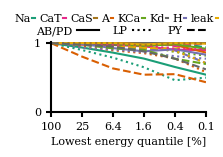

In [227]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 0.9))

    im = []
    counter = 0
    for f, c, s in zip(fracs.T[:24], cols, styles):
        image, = ax.plot(f, c=c, linestyle=s)
        if counter % 3 == 0:
            im.append(image)
        counter += 1

    _ = ax.set_xticks(range(len(eval_quantiles)))
    vals = 1-np.asarray(eval_quantiles)
    l = [str(round(100-float(100*label), 6)) for label in vals]
    l[0] = "100"
    l[1] = "25"
    _ = ax.set_xticklabels(l)
    ax.set_xlabel("Lowest energy quantile [%]")
    
    ims = []
    ims.append(ax.plot([10.0], [10.0], c="k", linestyle="solid")[0])
    ims.append(ax.plot([10.0], [10.0], c="k", linestyle="dotted")[0])
    ims.append(ax.plot([10.0], [10.0], c="k", linestyle="dashed")[0])
    
    ax.set_yticks([0., 1.])
    ax.set_ylim([0, 1.01])    
    ax.set_xlim([0, len(eval_quantiles)-1])
    leg1 = ax.legend(
        im,
        labels,
        loc="upper left",
        bbox_to_anchor=(-0.30, 1.05, 0.1, 0.5),
        labelspacing=0.3,
        columnspacing=0.4,
        markerfirst=False,
        handletextpad=0.15,
        handlelength=0.2,
        ncol=8,
    )
    leg2 = ax.legend(
        ims,
        labels2,
        loc="upper left",
        bbox_to_anchor=(-0.16, 0.88, 0.1, 0.5),
        labelspacing=0.3,
        columnspacing=1.2,
        markerfirst=False,
        handletextpad=0.4,
        handlelength=2.0,
        ncol=3,
    )
    ax.add_artist(leg1)
    plt.savefig(PANEL_degeneracy_plot, facecolor="None", transparent=False)

In [35]:
summed_energies = np.sum(x['energies'].to_numpy(), axis=1) / 10 / 1000
inds = np.argsort(summed_energies)
sorted_energies = summed_energies[inds]
quantiles = np.linspace(0, 1, 51)

In [36]:
fracs = []
for i in range(len(quantiles)-1):
    start_ind = int(len(summed_energies) * quantiles[i])
    end_ind = int(len(summed_energies) * quantiles[i+1])
    start_e = sorted_energies[start_ind]
    end_e = sorted_energies[np.minimum(35938, end_ind)]
    
    valid_inds = np.logical_and((summed_energies > start_e), (summed_energies < end_e))
    valid_theta = theta_np[valid_inds]
    
    std_of_min_energy = np.std(valid_theta, axis=0)
    std_of_all_samples = np.std(theta_np, axis=0)
    
    fracs.append(std_of_min_energy / std_of_all_samples)
fracs = np.asarray(fracs)
fracs[fracs > 1.0] = 1.0

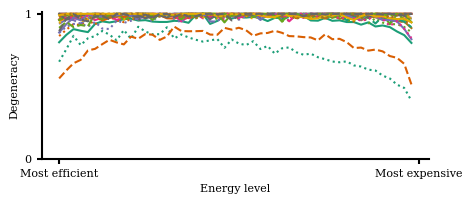

In [37]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(5.0, 1.9))

    for f, c, s in zip(fracs.T, cols, styles):
        _ = ax.plot(quantiles[:-1], f, c=c, linestyle=s)

    ax.set_xlabel("Energy level")
    ax.set_yticks([0., 1.])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Most efficient", "Most expensive"])
    ax.set_ylabel("Degeneracy")
#     ax.set_ylabel("Degeneracy")
    ax.set_ylim([0, 1.01])    
    plt.savefig("degeneracy_plot.png", dpi=300, bbox_inches="tight")
#     plt.savefig(PANEL_degeneracy_plot, facecolor="None", transparent=False)

### Randomized control trial

In [38]:
shuffled_energies = np.sum(x['energies'].to_numpy(), axis=1) / 10 / 1000
np.random.shuffle(shuffled_energies)
inds = np.argsort(shuffled_energies)
sorted_shuffled_energies = shuffled_energies[inds]

In [39]:
num_vals = sorted_shuffled_energies.shape[0]
fracs = []
eval_quantiles = np.flip(mylist)
for quantile in eval_quantiles:
    if quantile == 1.0:
        fracs.append([1.0]*31)
    else:
        one_percent_quantile = int(num_vals * quantile)
        one_percent_energy = sorted_shuffled_energies[one_percent_quantile]

        min_energy_condition = shuffled_energies < one_percent_energy
        min_energy_theta = theta_np[min_energy_condition]

        std_of_min_energy = np.std(min_energy_theta, axis=0)
        std_of_all_samples = np.std(theta_np, axis=0)

        fracs.append(std_of_min_energy / std_of_all_samples)

fracs = np.asarray(fracs)
# fracs[fracs > 1.0] = 1.0

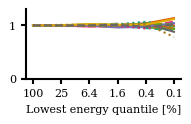

In [40]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 0.9))

    for f, c, s in zip(fracs.T, cols, styles):
        _ = ax.plot(f, c=c, linestyle=s)

    _ = ax.set_xticks(range(len(eval_quantiles)))
    vals = 1-np.asarray(eval_quantiles)
    l = [str(round(100-float(100*label), 6)) for label in vals]
    l[0] = "100"
    l[1] = "25"
    _ = ax.set_xticklabels(l)
    ax.set_xlabel("Lowest energy quantile [%]")
    ax.set_yticks([0., 1.])
#     ax.set_ylabel("Degeneracy")
    ax.set_ylim([0, 1.3])    
    plt.savefig("plot_jakob_pedro2.png", dpi=300, bbox_inches="tight")
#     plt.savefig(PANEL_degeneracy_plot, facecolor="None", transparent=False)

In [41]:
fitted_reg = np.load("../../../results/regression_nets/linear_regression.npy", allow_pickle=True).tolist()
mean_params = np.load("../../../results/regression_nets/linear_regression_theta_mean.npy", allow_pickle=True)
std_params = np.load("../../../results/regression_nets/linear_regression_theta_std.npy", allow_pickle=True)
mean_energy = np.load("../../../results/regression_nets/linear_regression_x_mean.npy", allow_pickle=True)
std_energy = np.load("../../../results/regression_nets/linear_regression_x_std.npy", allow_pickle=True)

In [42]:
theta_np_norm_lin = (theta_np - mean_params) / std_params
coef = fitted_reg.coef_[0]
np.random.shuffle(coef)
predicted_energy_norm = np.sum(theta_np_norm_lin * coef, axis=1) + fitted_reg.intercept_
predicted_energy = predicted_energy_norm * std_energy + mean_energy

In [43]:
shuffled_energies = predicted_energy
inds = np.argsort(shuffled_energies)
sorted_shuffled_energies = shuffled_energies[inds]

In [44]:
num_vals = sorted_shuffled_energies.shape[0]
fracs = []
eval_quantiles = np.flip(mylist)
for quantile in eval_quantiles:
    if quantile == 1.0:
        fracs.append([1.0]*31)
    else:
        one_percent_quantile = int(num_vals * quantile)
        one_percent_energy = sorted_shuffled_energies[one_percent_quantile]

        min_energy_condition = shuffled_energies < one_percent_energy
        min_energy_theta = theta_np[min_energy_condition]

        std_of_min_energy = np.std(min_energy_theta, axis=0)
        std_of_all_samples = np.std(theta_np, axis=0)

        fracs.append(std_of_min_energy / std_of_all_samples)

fracs = np.asarray(fracs)
fracs[fracs > 1.0] = 1.0

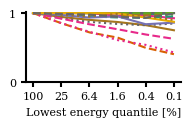

In [45]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 0.9))

    for f, c, s in zip(fracs.T, cols, styles):
        _ = ax.plot(f, c=c, linestyle=s)

    _ = ax.set_xticks(range(len(eval_quantiles)))
    vals = 1-np.asarray(eval_quantiles)
    l = [str(round(100-float(100*label), 6)) for label in vals]
    l[0] = "100"
    l[1] = "25"
    _ = ax.set_xticklabels(l)
    ax.set_xlabel("Lowest energy quantile [%]")
    ax.set_yticks([0., 1.])
#     ax.set_ylabel("Degeneracy")
    ax.set_ylim([0, 1.01]) 
    plt.savefig("plot_jakob_pedro.png", dpi=300, bbox_inches="tight")
#     plt.savefig(PANEL_degeneracy_plot, facecolor="None", transparent=False)

### Variance reduction plot

In [236]:
summed_energies = np.sum(x['energies'].to_numpy(), axis=1) / 10 / 1000

In [237]:
inds = np.argsort(summed_energies)

In [238]:
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
quantile = 0.02
one_percent_quantile = int(num_vals * quantile)
ninenine_percent_quantile = int(num_vals * (1-quantile))
one_percent_energy = sorted_energies[one_percent_quantile]
ninenine_percent_energy = sorted_energies[ninenine_percent_quantile]

In [239]:
min_energy_condition = summed_energies < one_percent_energy
max_energy_condition = summed_energies > ninenine_percent_energy

In [240]:
min_energy_theta = theta_np[min_energy_condition]
max_energy_theta = theta_np[max_energy_condition]

min_energy_energies = summed_energies[min_energy_condition]
max_energy_energies = summed_energies[max_energy_condition]

In [241]:
prior = create_prior(as_torch_dist=True)
lower_b = prior.support.base_constraint.lower_bound.unsqueeze(0)
upper_b = prior.support.base_constraint.upper_bound.unsqueeze(0)
limits = torch.cat((lower_b, upper_b), dim=0).T

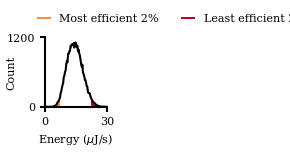

In [281]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(0.8, 0.9))
    vals, xvals = np.histogram(summed_energies, bins=100, range=[0, 30])
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, c='k')
    _, _, one = ax.hist(min_energy_energies, bins=100, range=[0, 30], color='#fd8d3c')
    _, _, two = ax.hist(max_energy_energies, bins=100, range=[0, 30], color='#bd0026')
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_ylabel("Count", labelpad=-7)
    ax.set_xlim([0, 30])
    ax.set_xticks([0, 30])
    ax.set_yticks([0, 1200])
    leg = ax.legend([one, two], ["Most efficient 2%", "Least efficient 2%"], ncol=3, loc=((-0.2, 1.13)), handletextpad=0.02)
    for line in leg.get_patches():
        line.set_height(1.6)
        line.set_width(10.0)
        line.set_y(2.3)
    plt.savefig(PANEL_supp_shift1, facecolor="None", transparent=False)

In [243]:
std_of_min_energy = np.std(min_energy_theta, axis=0)
std_of_all_samples = np.std(theta_np, axis=0)

In [160]:
stds_fraction = 1 - (std_of_min_energy / std_of_all_samples)

In [161]:
1- stds_fraction

array([0.8037193 , 0.8464843 , 0.9300234 , 0.95980245, 0.99449205,
       0.94929683, 1.0431094 , 1.0038784 , 1.044511  , 0.9603026 ,
       0.86817485, 1.0000968 , 0.9569214 , 0.93456495, 1.020405  ,
       1.0002675 , 0.6696571 , 0.554467  , 0.8713912 , 0.9851734 ,
       0.902615  , 0.99208903, 0.9757338 , 0.8798166 , 0.91078734,
       0.9658037 , 0.90537155, 1.1536438 , 0.93125415, 0.9684211 ,
       1.1299083 ], dtype=float32)

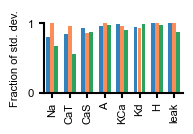

In [162]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        1.0 - deepcopy(torch.as_tensor(stds_fraction)),
        ylim=[0.0, 1.0],
        figsize=(1.8, 0.9),
        ylabel="Fraction of std. dev.",
        title=None,
        title_x_offset=-1.1,
        title_y_offset=0.1,
        legend_y_offset=0.3,
        legend=False,
        yticks=[0, 1],
        ylabelpad=5.5,
        rotation=90,
        spacing=0.23
    )
    plt.savefig(PANEL_supp_shift7, facecolor="None", transparent=False)
    plt.savefig("membrane.png", dpi=200, bbox_inches="tight")
    plt.show()

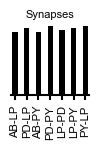

In [163]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        1.0 - deepcopy(torch.as_tensor([stds_fraction[-7:]])),
        ylim=[0.0, 1.0], 
        figsize=(1.0, 0.9), 
        ylabel=None, 
        color="k", 
        title="Synapses",
        width_multiplier=0.5
    )
    plt.savefig(PANEL_Synapses_reduction, facecolor="None", transparent=False)
    plt.savefig("synapses.png", dpi=200, bbox_inches="tight")
    plt.show()

### Effect of enforcing energy efficiency on the mean of the parameters

In [87]:
mean_of_min_energy = np.mean(min_energy_theta, axis=0)
mean_of_all_samples = np.mean(theta_np, axis=0)

mean_shift = torch.as_tensor(mean_of_min_energy) - mean_of_all_samples

In [88]:
mean_shift_within_prior = torch.as_tensor(mean_shift) / (limits[:, 1] - limits[:, 0])

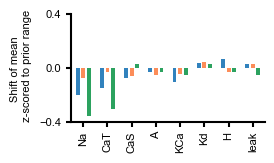

In [119]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        mean_shift_within_prior,
        ylim=[-0.4, 0.4],
        figsize=(2.5, 1.4),
        ylabel="Shift of mean \n z-scored to prior range",
        title=None,
        title_x_offset=-1.1,
        title_y_offset=0.1,
        legend_y_offset=0.3,
        legend=False,
        yticks=[-0.4, 0.0, 0.4],
        ylabelpad=5.5,
        rotation=90,
        spacing=0.23
    )
    plt.savefig(PANEL_supp_mean_shift, facecolor="None", transparent=False)
    plt.show()

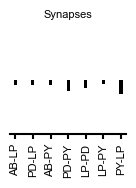

In [120]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        mean_shift_within_prior[-7:].unsqueeze(0),
        ylim=[-0.4, 0.4],
        figsize=(1.5, 1.4), 
        ylabel=None, 
        color="k", 
        title="Synapses",
        width_multiplier=0.3
    )
    plt.savefig(PANEL_supp_mean_shift_syn, facecolor="None", transparent=False)
    plt.show()

### Concrete plots

In [174]:
labels_ = get_labels_8pt()

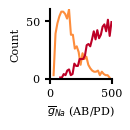

In [175]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(0.8, 0.9))
    ind=0
    vals, xvals = np.histogram(min_energy_theta[:, ind], bins=30)
    val_dist = xvals[1] - xvals[0]
    one, = ax.plot(xvals[1:] - val_dist/2, vals, color='#fd8d3c')
#     vals, xvals = np.histogram(theta_np[:, ind], bins=30)
#     val_dist = xvals[1] - xvals[0]
#     ax.plot(xvals[1:] - val_dist/2, vals/30, color='k', alpha=0.7)
    vals, xvals = np.histogram(max_energy_theta[:, ind], bins=30)
    two, = ax.plot(xvals[1:], vals, color='#bd0026')
    ax.set_xlabel(r"$\overline{g}_{Na}$ (AB/PD)")
    ax.set_ylabel("Count")
    ax.set_xlim(limits[ind])
    ax.set_xticks(limits[ind])
#     ax.legend([one, two], ["Most efficient 2%", "Least efficient 2%"], ncol=3, loc=((0.0, 1)))
    ax.set_ylim(bottom=0)
    ax.set_ylim([0, 60])
    plt.savefig(PANEL_supp_shift2, facecolor="None", transparent=False)

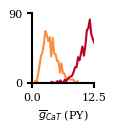

In [244]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(0.8, 0.9))
    ind = 17
    vals, xvals = np.histogram(min_energy_theta[:, ind], bins=30)
    val_dist = xvals[1] - xvals[0]
    one, = ax.plot(xvals[1:] - val_dist/2, vals, color='#fd8d3c')
    vals, xvals = np.histogram(max_energy_theta[:, ind], bins=30)
    two, = ax.plot(xvals[1:], vals, color='#bd0026')
    ax.set_xlabel(r"$\overline{g}_{CaT}$ (PY)")
    ax.set_xlim(limits[ind])
    ax.set_xticks(limits[ind])
    ax.set_ylim(bottom=0)
    ax.set_yticks([0, 90])
#     ax.legend([one, two], ["Most efficient 2%", "Least efficient 2%"], ncol=3, loc=((0.0, 1)))
    plt.savefig(PANEL_supp_shift3, facecolor="None", transparent=False)

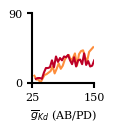

In [288]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(0.8, 0.9))
    ind = 5
    vals, xvals = np.histogram(min_energy_theta[:, ind], bins=30)
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, color='#fd8d3c')
    vals, xvals = np.histogram(max_energy_theta[:, ind], bins=30)
    ax.plot(xvals[1:], vals, color='#bd0026')
    ax.set_xlabel(r"$\overline{g}_{Kd}$ (AB/PD)")
    ax.set_xlim(limits[ind])
    ax.set_xticks(limits[ind])
    ax.set_ylim(bottom=0)
#     ax.set_yticklabels([])
    ax.set_yticks([0, 90])
    ax.set_ylim([0, 90])
    plt.savefig(PANEL_supp_shift4, facecolor="None", transparent=False)

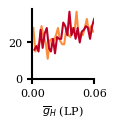

In [178]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(0.8, 0.9))
    ind = 14
    vals, xvals = np.histogram(min_energy_theta[:, ind], bins=30)
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, color='#fd8d3c')
    vals, xvals = np.histogram(max_energy_theta[:, ind], bins=30)
    ax.plot(xvals[1:], vals, color='#bd0026')
    ax.set_xlabel(r"$\overline{g}_{H}$ (LP)")
    ax.set_xlim(limits[ind])
    ax.set_xticks(limits[ind])
    ax.set_ylim(bottom=0)
    plt.savefig(PANEL_supp_shift5, facecolor="None", transparent=False)

### Panel C

In [179]:
prior = create_prior(as_torch_dist=True)
lower_b = prior.support.base_constraint.lower_bound.unsqueeze(0)
upper_b = prior.support.base_constraint.upper_bound.unsqueeze(0)
limits = torch.cat((lower_b, upper_b), dim=0).T 

In [180]:
npz = np.load('../../../results/experimental_data/trace_data_845_082_0044.npz')
t = npz['t']
PD_spikes = npz['PD_spikes']
LP_spikes = npz['LP_spikes']
PY_spikes = npz['PY_spikes']
pdn = npz['pdn']
lpn = npz['lpn']
pyn = npz['pyn']
start_index = 219500 + 2100
end_index   = 246500 + 2100  # 32000
height_offset = 200
shown_t = t[end_index] - t[start_index]
time_len = shown_t / 0.025 * 1000
dt = t[1] - t[0]
time_vec = np.arange(0, 11000, 0.025)

In [181]:
inds = np.argsort(summed_energies)
quantile = 0.00015
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
one_percent_quantile = int(num_vals * quantile)
one_percent_energy = sorted_energies[one_percent_quantile]

In [182]:
min_energy_condition = summed_energies < one_percent_energy
min_energy_theta = theta_np[min_energy_condition]
min_energy_energies = summed_energies[min_energy_condition]
min_energy_x = x[min_energy_condition]
min_energy_seed = seeds[min_energy_condition]

In [183]:
labels_ = get_labels_8pt()
lims=limits.numpy()
all_labels = generate_labels_for_pairplot_no_whitespace(lims)

/home/michael/Documents/STG_energy_sbi/sbi/utils/plot.py:563: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:


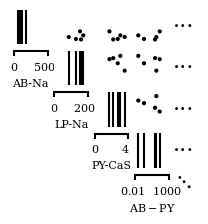

In [184]:
with mpl.rc_context(fname='../../../.matplotlibrc'):

    labels_new = get_labels_8pt()
    new_labels = []
    for l in labels_new:
        new_labels.append(l+'    '+r'$\;\;$')
    labels_new = new_labels
    labels_new[9] += ''

    fig, axes = pairplot(
        samples=min_energy_theta,
        subset=[0,8,18,26],
        labelpad=1,
        tick_labelpad=1,
        limits=limits,
        ticks=limits,
        tick_labels=all_labels,
        figsize=(2.0, 2.0),
        labels=labels_,
        scatter_offdiag={'rasterized':True, 'alpha':1.0},
        diag=['scatter'],
        upper=['scatter'],
        samples_colors="k",
        hist_offdiag={'bins':50},
        plot_offdiag={'linewidth': 1.6, 'path_effects':[pe.Stroke(linewidth=2.4, foreground='k'), pe.Normal()]}
    )
    plt.savefig(PANEL_NEW_A, facecolor='None', transparent=True)

### Panel E

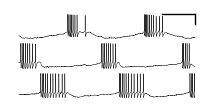

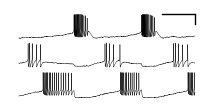

In [185]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    viz.plot_overall_efficient(
        1, min_energy_theta, min_energy_seed, time_vec, time_len, offset=90000, figsize=(2.5, 1.2)
    )
    plt.savefig("1a.png", dpi=200, bbox_inches="tight")
    plt.savefig(PANEL_NEW_F1, facecolor='None', transparent=True)

    viz.plot_overall_efficient(
        3, min_energy_theta, min_energy_seed, time_vec, time_len, figsize=(2.5, 1.2)
    )
    plt.savefig("1b.png", dpi=200, bbox_inches="tight")
    plt.savefig(PANEL_NEW_F2, facecolor='None', transparent=True)

### Panel F

3.88169053624513
4.163538616011244


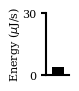

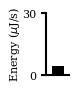

In [186]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    viz.plot_energy_of_theta(
        1, min_energy_theta, min_energy_seed, time_vec, time_len, offset=90000, figsize=(0.3, 0.8)
    )
    plt.savefig("2a.png", dpi=200, bbox_inches="tight")
    plt.savefig(PANEL_NEW_G1, facecolor='None', transparent=True)

    viz.plot_energy_of_theta(
        3, min_energy_theta, min_energy_seed, time_vec, time_len, figsize=(0.3, 0.8)
    )
    plt.savefig("2b.png", dpi=200, bbox_inches="tight")
    plt.savefig(PANEL_NEW_G2, facecolor='None', transparent=True)

### Panel G

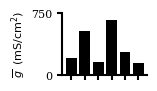

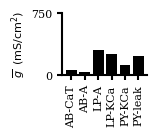

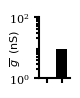

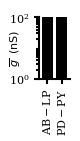

In [187]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    viz.plot_params(deepcopy(min_energy_theta[1]), [1, 3, 11, 12, 20, 23, 24, 27], labels=False, width=1.1, ylim=[0, 750], labelpad=2, height=0.8)
    plt.savefig("3a.png", dpi=200, bbox_inches="tight")
    plt.savefig(PANEL_NEW_supp_params_11, facecolor='None', transparent=True)
    viz.plot_params(deepcopy(min_energy_theta[3]), [1, 3, 11, 12, 20, 23, 24, 27], width=1.1, ylim=[0, 750], labelpad=2, height=0.8)
    plt.savefig("3b.png", dpi=200, bbox_inches="tight")
    plt.savefig(PANEL_NEW_supp_params_12, facecolor='None', transparent=True)

    viz.plot_synapses(deepcopy(min_energy_theta[1]), [1, 3, 11, 12, 20, 23, 24, 27], labels=False, width=0.4, height=0.8)
    plt.savefig("3c.png", dpi=200, bbox_inches="tight")
    plt.savefig(PANEL_NEW_supp_params_21, facecolor='None', transparent=True)
    viz.plot_synapses(deepcopy(min_energy_theta[3]), [1, 3, 11, 12, 20, 23, 24, 27], width=0.4, height=0.8)
    plt.savefig("3d.png", dpi=200, bbox_inches="tight")
    plt.savefig(PANEL_NEW_supp_params_22, facecolor='None', transparent=True)

### Assemble figure

In [188]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [293]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_blue = {'size': '7.7pt', 'font': 'Arial', 'weight': '500', 'color': "#0570b0"}

f = Figure("20.3cm", "9.9cm",

    Panel(
          SVG(PANEL_supp_shift1).scale(svg_scale).move(0, 0*factor_svg),
        Text("a", 1.2*factor_svg, 3.6*factor_svg, **kwargs_text),
    ).move(-1.2*factor_svg, -1.2*factor_svg),
           
    Panel(
          SVG(PANEL_supp_shift3).scale(svg_scale).move(0, 0*factor_svg),
    ).move(16.7*factor_svg, 2.75*factor_svg),
    
    Panel(
          SVG(PANEL_supp_shift4).scale(svg_scale).move(0, 0*factor_svg),
    ).move(32.5*factor_svg, 2.75*factor_svg),
    
    Panel(
          SVG(PANEL_Synapses_reduction).scale(svg_scale).move(0, 0*factor_svg),
    ).move(87.0*factor_svg, 0.8*factor_svg),

    Panel(
          SVG(PANEL_supp_shift7).scale(svg_scale).move(0, 0*factor_svg),
          Text("b", -1.15*factor_svg, 1.2*factor_svg, **kwargs_text),
    ).move(55.65*factor_svg, 1.2*factor_svg),
           
    Panel(
          SVG("../svg/panel_legend_4cols.svg").scale(svg_scale).move(0, 0*factor_svg),
    ).move(65.2*factor_svg, 2.1*factor_svg),

    Panel(
          SVG(PANEL_degeneracy_plot).scale(svg_scale).move(0, 0*factor_svg),          
        Text("c", -0.5*factor_svg, 4.3*factor_svg, **kwargs_text),
    ).move(103.0*factor_svg, -1.9*factor_svg),
           
    Panel(
          SVG(PANEL_NEW_A).scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
          Text("d", -2*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 27*factor_svg),

    Panel(
        SVG(PANEL_NEW_F1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("e", -.0*factor_svg, 2.8*factor_svg, **kwargs_text),
    ).move(44.0*factor_svg, 25.7*factor_svg),

    Panel(
        SVG(PANEL_NEW_F2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(44.0*factor_svg, 45.5*factor_svg),

    Panel(
        SVG(PANEL_NEW_G1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("f", -2.2*factor_svg, 1.7*factor_svg, **kwargs_text),
    ).move(86.7*factor_svg, 26.8*factor_svg),
           
    Panel(
        SVG(PANEL_NEW_G2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(86.7*factor_svg, 46.5*factor_svg),

    Panel(
        SVG(PANEL_NEW_supp_params_11).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("g", -1.7*factor_svg, 1.7*factor_svg, **kwargs_text),
    ).move(103.7*factor_svg, 26.8*factor_svg),

    Panel(
        SVG(PANEL_NEW_supp_params_12).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(103.7*factor_svg, 46.5*factor_svg),

    Panel(
        SVG(PANEL_NEW_supp_params_21).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(127.5*factor_svg, 26.8*factor_svg),

    Panel(
        SVG(PANEL_NEW_supp_params_22).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(127.5*factor_svg, 46.5*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_1.svg")
svg('../fig/fig3_1.svg')

In [150]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_blue = {'size': '7.7pt', 'font': 'Arial', 'weight': '500', 'color': "#0570b0"}

f = Figure("20.3cm", "4.3cm",

    Panel(
          SVG(PANEL_supp_mean_shift).scale(svg_scale).move(0, 0*factor_svg),
    ).move(0*factor_svg, 1.05*factor_svg),
           
    Panel(
          SVG(PANEL_supp_mean_shift_syn).scale(svg_scale).move(0, 0*factor_svg),
    ).move(45.7*factor_svg, -1*factor_svg),
    
    Panel(
          SVG("../svg/panel_legend_4cols.svg").scale(svg_scale).move(0, 0*factor_svg),
    ).move(17.2*factor_svg, 0.31*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_1_supp_mean_shift.svg")
svg('../fig/fig3_1_supp_mean_shift.svg')